# Train a DNN using RDKit
This notebook illustrates how to train a Deep Neural Network on the SMRT dataset using fingerprints computed with RDKit. To get started, make sure you have installed `cmmrt` and `RDKit`.

In [1]:
%%bash
echo $LD_LIBRARY_PATH

/opt/ohpc/pub/apps/python/3.8.2/lib:/opt/ohpc/pub/mpi/openmpi3-gnu8/3.1.4/lib:/opt/ohpc/pub/compiler/gcc/8.3.0/lib64:/opt/ohpc/pub/apps/cuda/11.0/lib64:/opt/ohpc/pub/apps/cuda112/neuralnet/8.1.1/lib64


In [1]:
# This steps were done in the command line

# %%capture
# !pip install rdkit-pypi user # install RDKit 
# !make install -C .. # install cmmrt

## Loading the SMRT dataset
For convenience, we have included the retention times (RTs, in seconds) from the SMRT dataset in the `SMRT_rts.csv` file. Let's load it:

In [11]:
import pandas as pd
rt_df = pd.read_csv("SMRT_rts.csv", dtype={'pubchem': int, 'rt': float})
rt_df.head()

,pubchem,rt
0,191,92.7
1,253,633.5
2,298,735.1
3,409,89.6
4,471,687.4


In [12]:
rt_df.shape

(80038, 2)

The file just consists of pairs of PubChem IDs and the retention times from the SMRT dataset. There are more than 80000 molecules, so let's subsample the dataframe to avoid large training times. Also, we can stratify the dataset so that the subsampled dataframe is as representative as possible of the whole one.

In [3]:
n_strats = 6                    # number of strats for the stratified sampling
subsamples_by_group = 1000      # number of samples in each strats (there would be a total of n_strats * subsamples_by_group samples)


rt_df['rt_group'] = pd.qcut(rt_df['rt'], q=n_strats, labels=False)
rt_df = rt_df.groupby('rt_group').sample(n=subsamples_by_group, random_state=100)
print(f"SMRT dataset after subsampling has shape {rt_df.shape}")

SMRT dataset after subsampling has shape (6000, 3)


In [ ]:
rt_df.to_csv('rt_sampled.csv')

In [4]:
rt_df.head()

,pubchem,rt,rt_group
21808,46278991,610.2,0
54078,53155764,583.7,0
64051,53196723,569.8,0
75923,110196171,572.0,0
51293,53143710,593.4,0


Since the dataframe contains only PubChem IDs and RTs we first need to compute some useful features of each molecule to used them for RT prediction. We shall use RDKit to compute the MACCS (Molecular ACCess System) keys. To compute the MACCS keys we need to proceed in two steps:
1. Retrieve information on the chemical structure and associated data of each compound (based on the PubChem ID).
2. Use the chemical information to compute MACCS keys using RDKit.

You may download SDF files containing the result of step 1 from [SDFs.zip](https://ceu365-my.sharepoint.com/:u:/g/personal/constantino_garciama_ceu_es/EdAQ5ExO_iBEn84vGreXihkBLFkNVXD3f2qKDJiPtokP8w?e=TSfOUt). After decompressing the file, we may proceed with step 2:

Since the link is broken, SDF files will be obtained through the **requests** package.

In [4]:
import requests

s = requests.Session()
main_url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/"

In [5]:
from time import sleep

pb_ids = rt_df['pubchem']

i = 0
for id in pb_ids:
    query = main_url + str(id) + "/SDF"
    r = s.get(query).content
    txt = r.decode('utf-8')
    i +=1
    if(i % 5 == 0):
        print(i)
        sleep(1)

    with open('sdfs/' + str(id) + '.sdf', 'w') as f:
        f.write(txt)

5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
505
510
515
520
525
530
535
540
545
550
555
560
565
570
575
580
585
590
595
600
605
610
615
620
625
630
635
640
645
650
655
660
665
670
675
680
685
690
695
700
705
710
715
720
725
730
735
740
745
750
755
760
765
770
775
780
785
790
795
800
805
810
815
820
825
830
835
840
845
850
855
860
865
870
875
880
885
890
895
900
905
910
915
920
925
930
935
940
945
950
955
960
965
970
975
980
985
990
995
1000
1005
1010
1015
1020
1025
1030
1035
1040
1045
1050
1055
1060
1065
1070
1075
1080
1085
1090
1095
1100
1105
1110
1115
1120
1125
1130
1135
1140
1145
1150
1155
1160
1165
1170
1175
1180
1185
1190
1195
1200
1205
1210
1215
1220

In [5]:
import os
from rdkit.Chem import MACCSkeys
from rdkit.Chem.rdmolfiles import SDMolSupplier

sdfs_path = "sdfs"

def compute_maccs(row):
    filepath = os.path.join(sdfs_path, str(int(row.pubchem)) + ".sdf")
    mols_in_sdf = SDMolSupplier(filepath)
    assert len(mols_in_sdf) == 1, "There should be only one molecule in the sdf file"
    MACCSFP_fingerprint = MACCSkeys.GenMACCSKeys(mols_in_sdf[0])
    return pd.Series(list(MACCSFP_fingerprint.ToBitString()),
                     index=['bit_' + str(i) for i in range(MACCSFP_fingerprint.GetNumBits())])

In [6]:
fgps_df = rt_df.apply(compute_maccs, axis=1)
fgps_df = pd.concat([rt_df, fgps_df], axis=1)
fgps_df.head()

,pubchem,rt,rt_group,bit_0,bit_1,bit_2,bit_3,bit_4,bit_5,bit_6,...,bit_157,bit_158,bit_159,bit_160,bit_161,bit_162,bit_163,bit_164,bit_165,bit_166
21808,46278991,610.2,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,0
54078,53155764,583.7,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,0
64051,53196723,569.8,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,1,1,0
75923,110196171,572.0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
51293,53143710,593.4,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,1,1,0


Now that we have useful features for RT prediction, we may split our dataset on train and test sets. Since we have stratified the data based on the RTs, we can reuse the strats to obtain a representative test set:

In [7]:
from sklearn.model_selection import train_test_split

X = fgps_df[[column for column in fgps_df.columns if column.startswith('bit_')]].values.astype('float32')
y = fgps_df['rt'].values.astype('float32')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,
                                                    stratify=rt_df['rt_group'].values)

We can now train a predictor using the train data. Let us use the best regressor obtained in the paper 
> C.A. García, A. Gil-de-la-Fuente, C. Barbas, and A. Otero. **Evaluation of machine learning techniques forsmall molecule retention time prediction.** *(Under review)*.

That is, a DNN trained with warm restarts and Stochastic Weight Averaging (SWA). This can be easily done by importing the `SkDnn` class from the `cmmrt` package. The constructor has sensible defaults based on extensive hyperparameter search, and hence, we only need to specify which columns are binary (in this example, all of them).

In [8]:
import numpy as np
from cmmrt.rt.models.nn.SkDnn import SkDnn

dnn = SkDnn(binary_col_indices=np.arange(X.shape[1]))

The `Sk` part of the name is due to the fact that `SkDnn` is an `scikit-learn` regressor. Hence, we can easily train the regressor...

In [9]:
dnn.fit(X_train, y_train)

SkDnn(binary_col_indices=array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166]))

... and also test its performance on the test set:

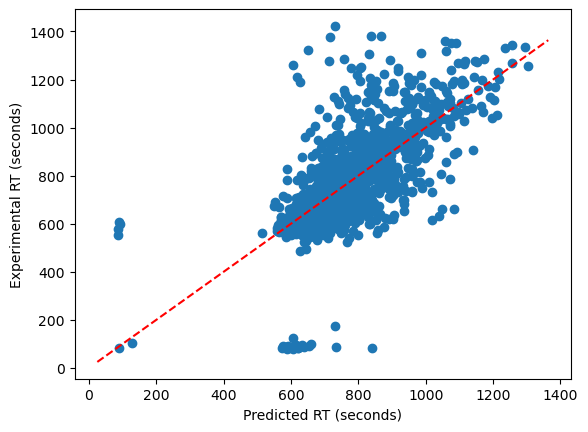

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

predictions = dnn.predict(X_test)

# Let's compare the predictions with the actual data with a scatterplot:
plt.scatter(predictions, y_test)
plt.xlabel('Predicted RT (seconds)')
plt.ylabel('Experimental RT (seconds)')
# Let's also add the ideal identity line (the closer the points to the line, the better the prediciton)
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
plt.plot(x_vals, x_vals, 'r--')
plt.show()